In [2]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.metrics import confusion_matrix

In [ ]:
# 1. SETUP & FILE PATHS


shapefile_path = "subs1.shp"
riv_path = "riv1.shp"
outlet_path = "outlets1.shp"

raster_files = {
    2013: "lu_2013_clip_reclass.tif",
    2018: "lu_2018_clip_reclass.tif",
    2023: "lu_2023_clip_reclass.tif"
}


reclass_map = {
    # Crops -> CORN
    1: 1, 5: 1, 24: 1,
    # Urban -> URBN (Removed 111 from here)
    121: 121, 122: 121, 123: 121, 124: 121,
    # Forest -> FRSD
    141: 142, 142: 142, 143: 142, 152: 142,
    # Others
    36: 36,   # ALFA
    176: 176,  # PAST
    131: 131,  # BARR
    111: 111,  # WATR (Now maps to 70)
    0: 1      # NoData
}


class_labels = {
    1: 'CORN', 121: 'URBN', 142: 'FRSD', 
    36: 'ALFA', 176: 'PAST', 131: 'BARR', 111: 'WATR', 0: 'NODATA'
}


cmap_colors = ['none', 'gold', 'darkorange', 'blue', 'red', 'grey', 'darkgreen', 'magenta']
custom_cmap = ListedColormap(cmap_colors)

norm = BoundaryNorm([0, 1, 36, 111, 121, 131, 142, 176, 180], len(cmap_colors))

In [ ]:
# 2. HELPER FUNCTIONS

def reclassify_array(arr, mapping):
    """Reclassifies a numpy array using the mapping dictionary."""
    new_arr = np.copy(arr)
    for k, v in mapping.items():
        new_arr[arr == k] = v
    return new_arr

def reclassify_array(arr, mapping):
    """
    Reclassifies array. 
    - 0 remains 0 (NoData).
    - Keys in mapping -> Values.
    - ANYTHING ELSE -> 100 (OTHER).
    """

    new_arr = np.full(arr.shape, 0, dtype=arr.dtype)
    

    new_arr[arr == 0] = 0
    

    for k, v in mapping.items():
        new_arr[arr == k] = v
        
    return new_arr

def analyze_subbasins(gdf, raster_dict):
    """Clips rasters by subbasin, reclassifies, and calculates stats."""
    results = []
    
    for idx, row in gdf.iterrows():
        sub_id = row.get('Subbasin', idx) # Use 'Subbasin' column if exists, else index
        geom = [row['geometry']]
        
        sub_data = {'Subbasin': sub_id}
        
        for year, r_path in raster_dict.items():
            with rasterio.open(r_path) as src:
                # Clip
                out_image, out_transform = mask(src, geom, crop=True)
                data = out_image[0]
                
                # Reclassify
                reclassed = reclassify_array(data, reclass_map)
                
                # Count
                unique, counts = np.unique(reclassed, return_counts=True)
                total_pixels = counts[unique != 0].sum()
                
                for code, label in class_labels.items():
                    if code == 0: continue
                    if code in unique:
                        count = counts[unique == code][0]
                        pct = (count / total_pixels) * 100
                    else:
                        pct = 0
                    sub_data[f'{label}_{year}'] = pct
                    
        results.append(sub_data)
    return pd.DataFrame(results)

In [ ]:
# 3. RUN ANALYSIS & CALCULATE CHANGES

# A. Load Shapefile
print("Loading Shapefile...")
gdf = gpd.read_file(shapefile_path)
gdf_riv = gpd.read_file(riv_path)
gdf_outlet = gpd.read_file(outlet_path)

# Ensure CRS matches Raster
with rasterio.open(raster_files[2023]) as src:
    raster_crs = src.crs
    if gdf.crs != raster_crs:
        print(f"Reprojecting shapefile from {gdf.crs} to {raster_crs}...")
        gdf = gdf.to_crs(raster_crs)

# B. Calculate Statistics
print("Calculating Land Use Statistics per Subbasin...")
df_stats = analyze_subbasins(gdf, raster_files)

# C. Calculate Changes for Matrix Plots
lu_types = [l for l in class_labels.values() if l != 'NODATA']

# 1. Change 2013 -> 2018
cols_13_18 = []
for lu in lu_types:
    col_name = f'{lu}_Chg_13_18'
    df_stats[col_name] = df_stats[f'{lu}_2018'] - df_stats[f'{lu}_2013']
    cols_13_18.append(col_name)

# 2. Change 2018 -> 2023
cols_18_23 = []
for lu in lu_types:
    col_name = f'{lu}_Chg_18_23'
    df_stats[col_name] = df_stats[f'{lu}_2023'] - df_stats[f'{lu}_2018']
    cols_18_23.append(col_name)

# 3. Overall Change (for the bar plot)
for lu in lu_types:
    df_stats[f'{lu}_Change'] = df_stats[f'{lu}_2023'] - df_stats[f'{lu}_2013']

print("Analysis Complete. Columns updated.")

Loading Shapefile...
Calculating Land Use Statistics per Subbasin...
Analysis Complete. Columns updated.


In [6]:
gdf_6 = gdf[gdf['Subbasin']==6]
gdf_15 = gdf[gdf['Subbasin']==15]

In [7]:
gdf_outlet = gdf_outlet[gdf_outlet['GRID_CODE'].isin([7,16])]

Generating Map...


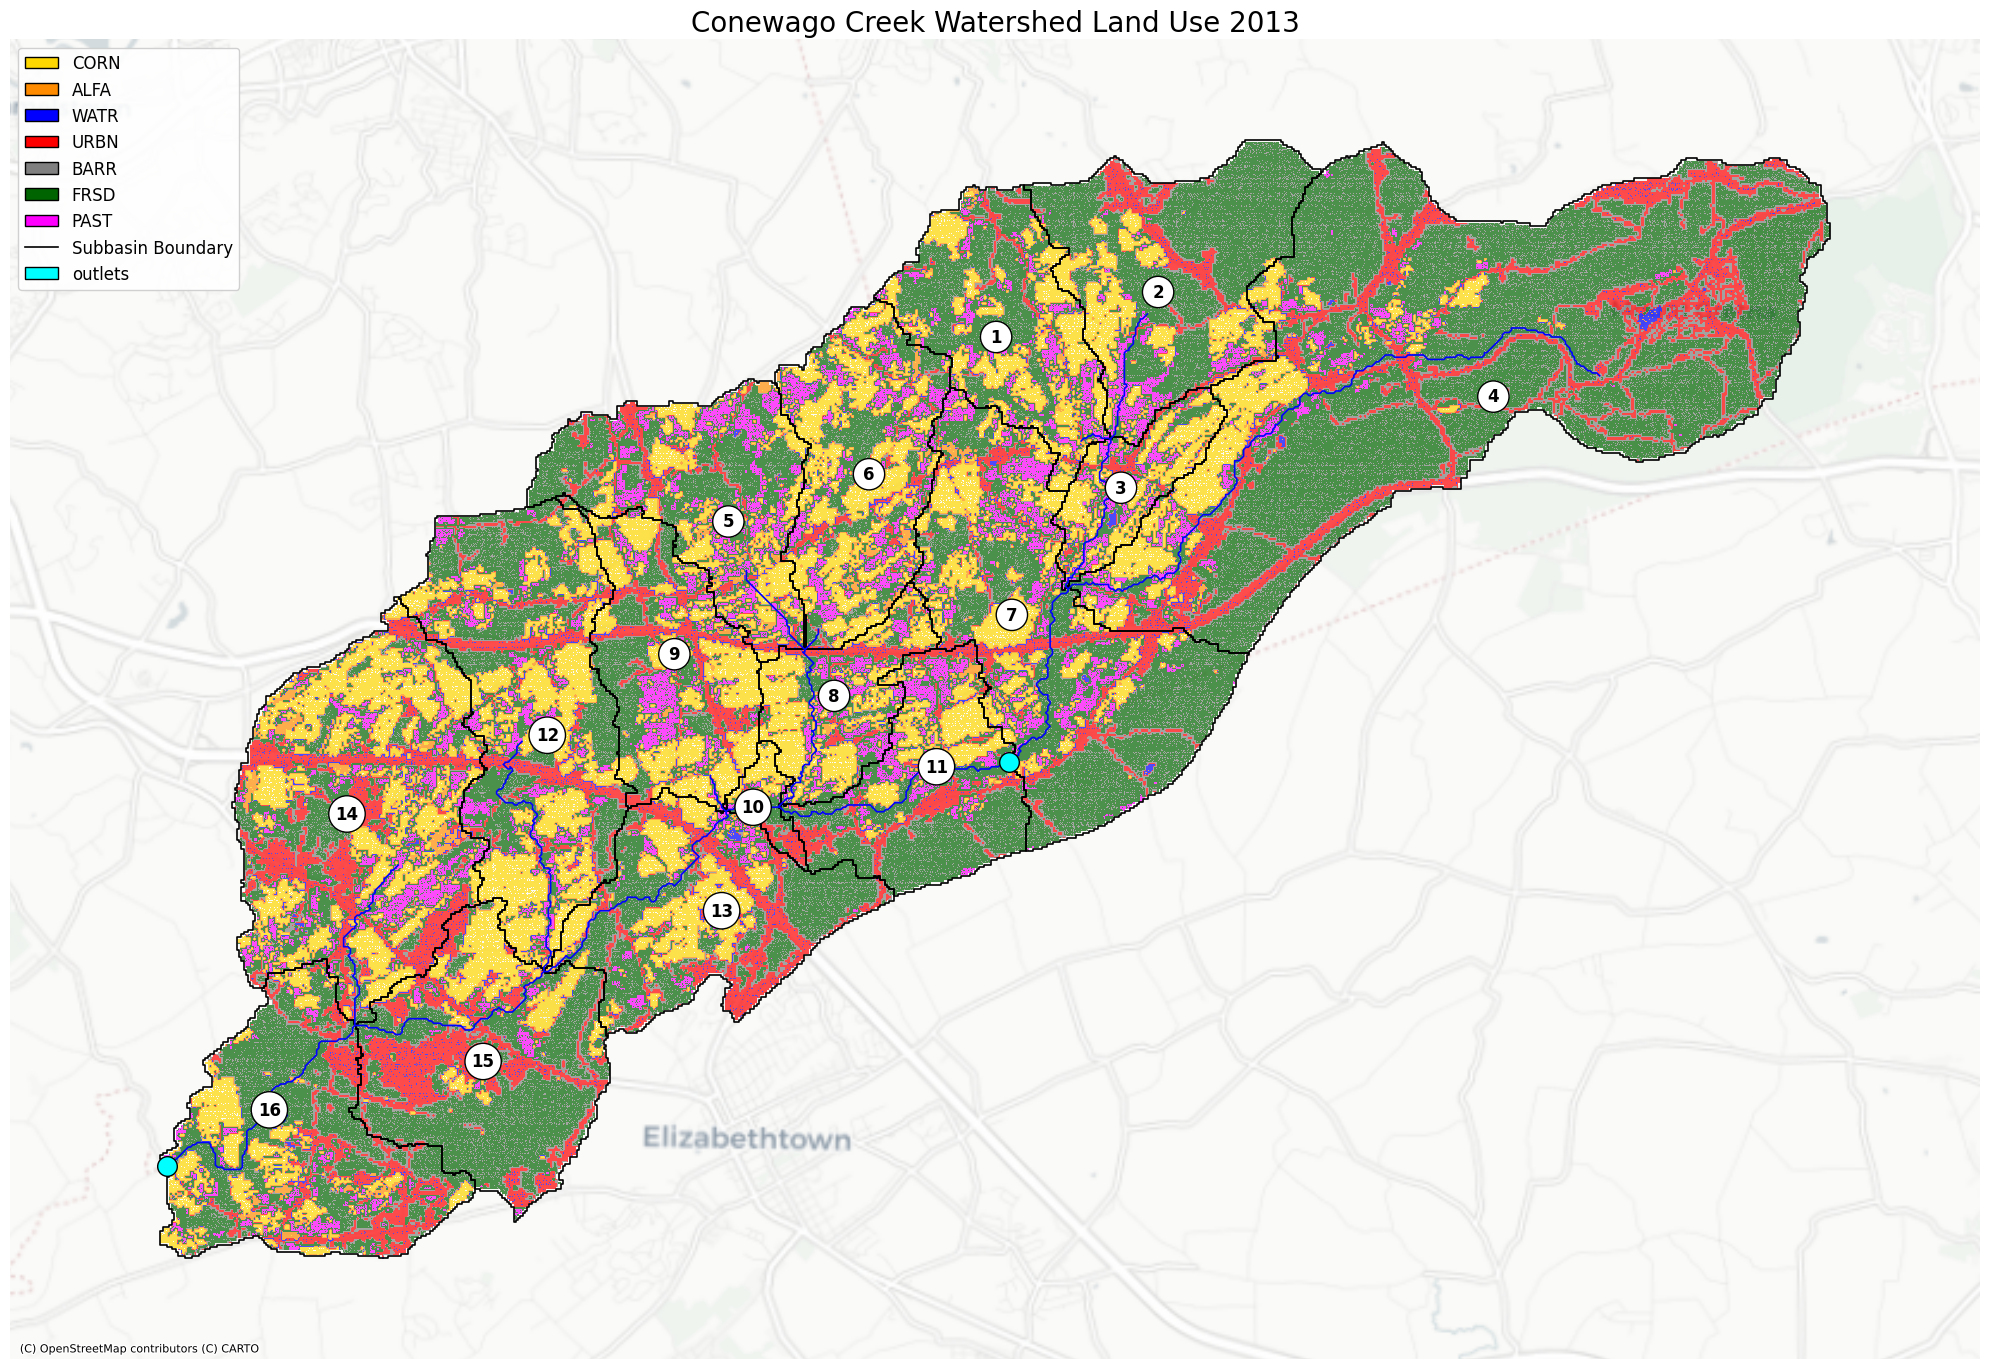

In [ ]:
# 4. VISUALIZATIONS

# --- PLOT 1.1: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2013)
with rasterio.open(raster_files[2013]) as src:
    out_img, out_transform = mask(src, gdf.geometry, crop=True)
    reclassed_2013 = reclassify_array(out_img[0], reclass_map)
    
    reclassed_2013 = reclassed_2013.astype('float')
    reclassed_2013[reclassed_2013 == 0] = np.nan
    
    show(reclassed_2013, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=200, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom
xmin, ymin, xmax, ymax = gdf.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Conewago Creek Watershed Land Use 2013", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 200, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.savefig('LUmap2013.png', dpi=600)
plt.show()

Generating Map...


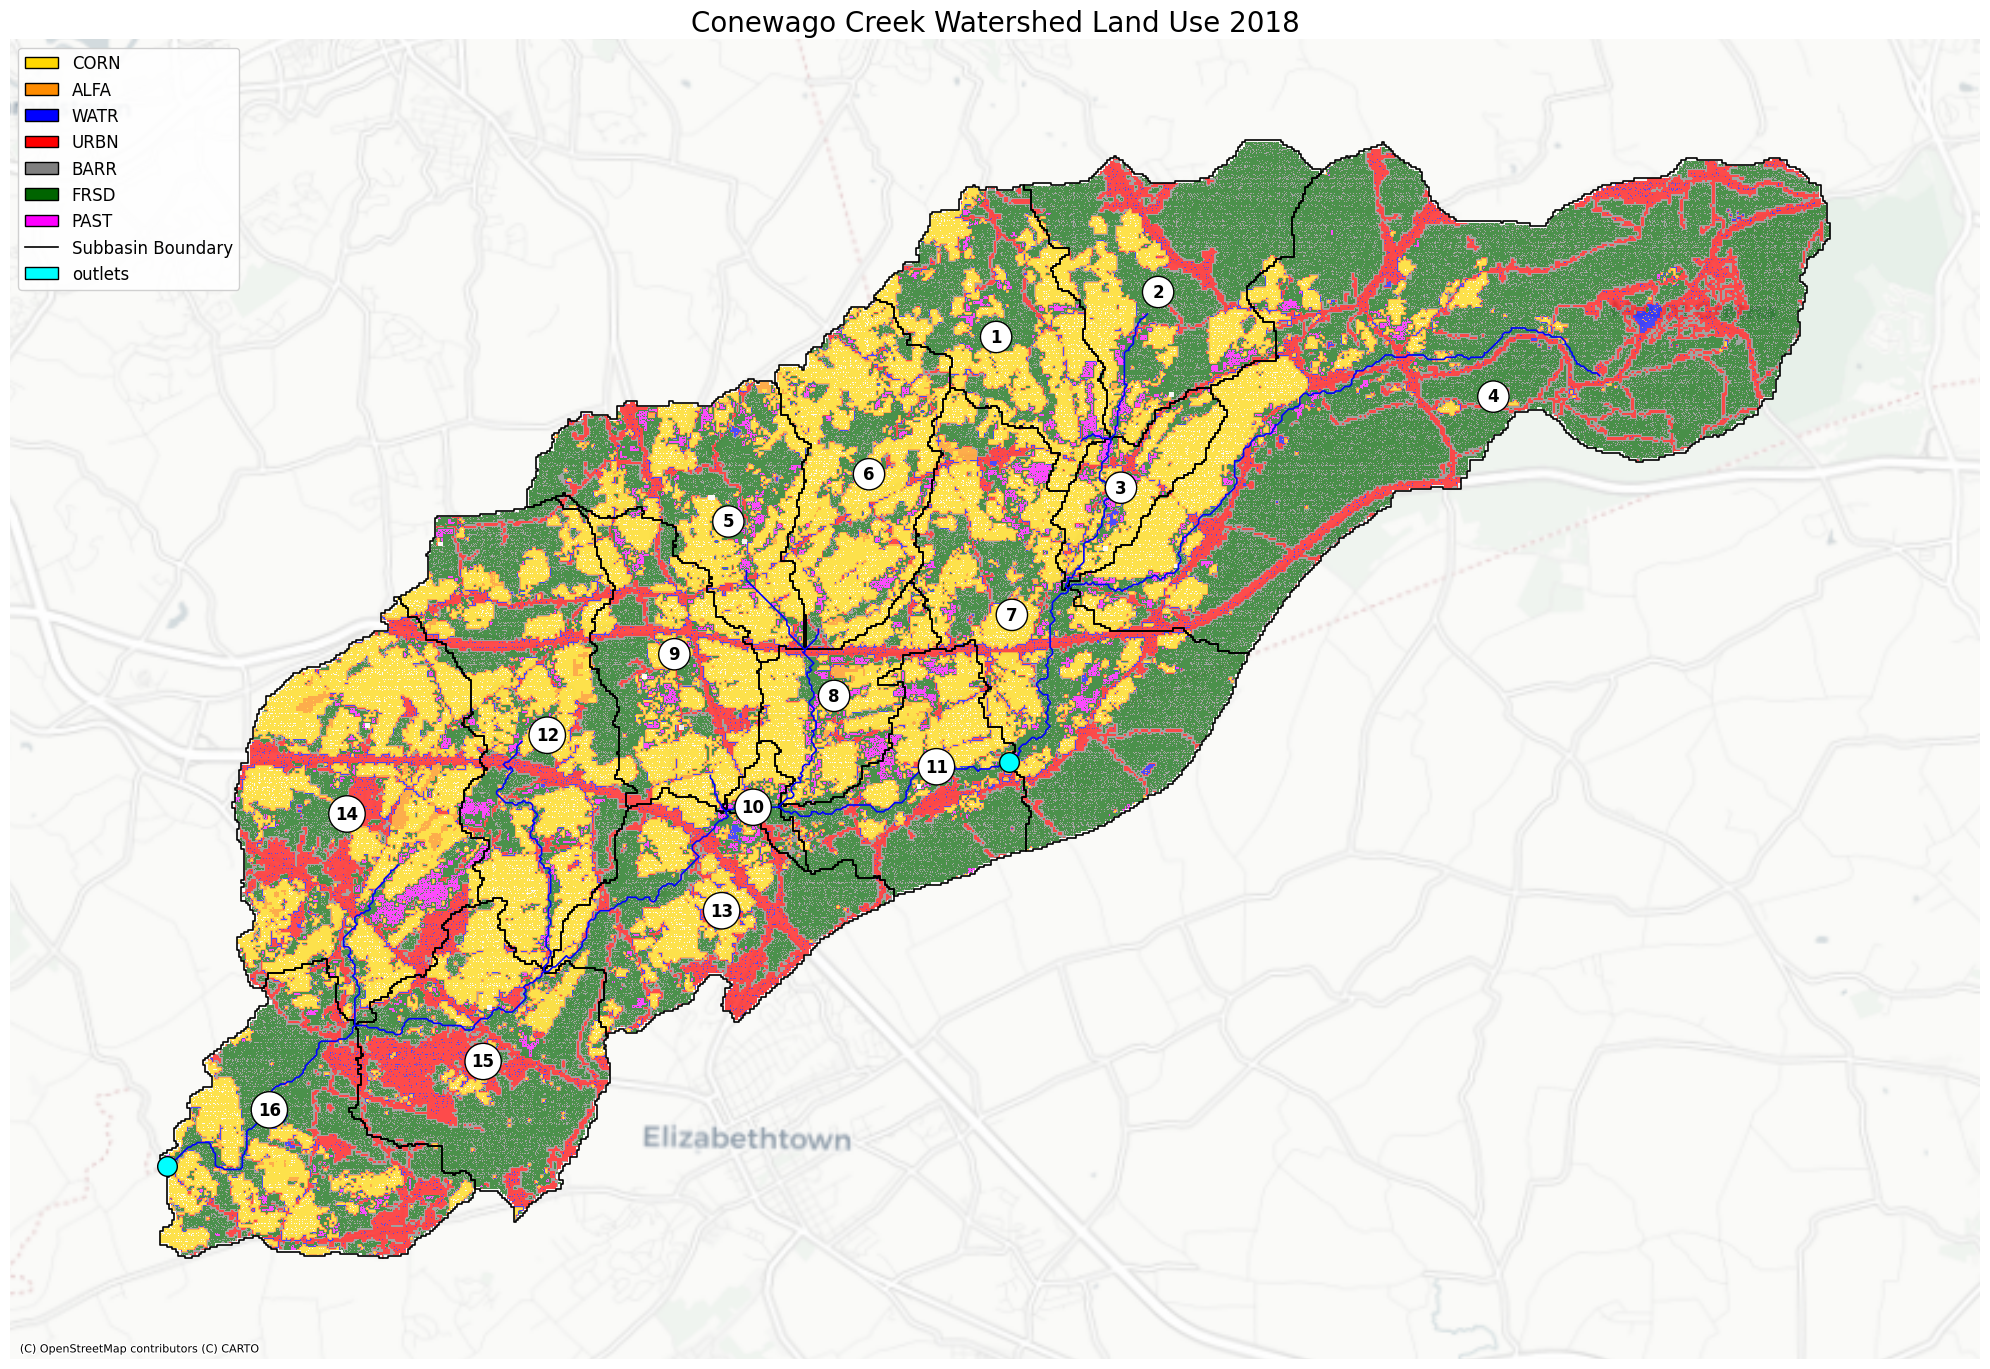

In [ ]:
# --- PLOT 1.2: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2018)
with rasterio.open(raster_files[2018]) as src:
    out_img, out_transform = mask(src, gdf.geometry, crop=True)
    reclassed_2018 = reclassify_array(out_img[0], reclass_map)
    
    reclassed_2018 = reclassed_2018.astype('float')
    reclassed_2018[reclassed_2018 == 0] = np.nan
    
    show(reclassed_2018, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=200, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom
xmin, ymin, xmax, ymax = gdf.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Conewago Creek Watershed Land Use 2018", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 200, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.savefig('LUmap2018.png', dpi=600)
plt.show()

Generating Map...


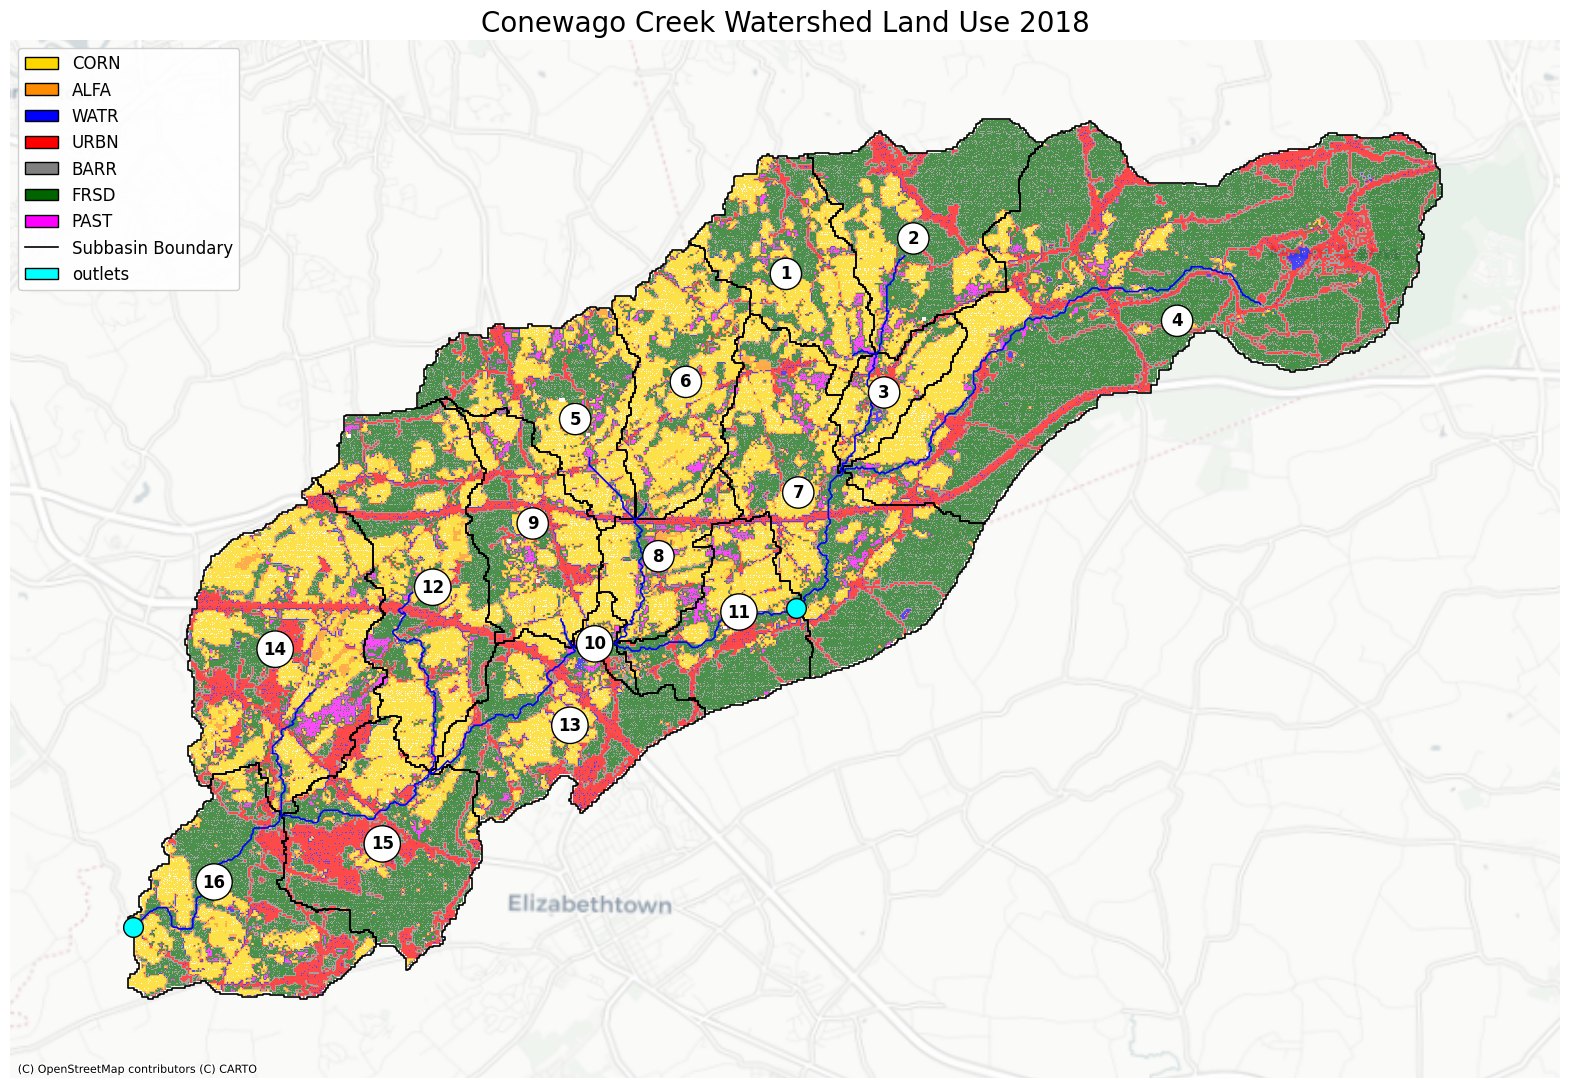

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- PLOT 1.2: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2018)
with rasterio.open(raster_files[2018]) as src:
    out_img, out_transform = mask(src, gdf.geometry, crop=True)
    reclassed_2018 = reclassify_array(out_img[0], reclass_map)
    
    reclassed_2018 = reclassed_2018.astype('float')
    reclassed_2018[reclassed_2018 == 0] = np.nan
    
    show(reclassed_2018, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=200, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom
xmin, ymin, xmax, ymax = gdf.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Conewago Creek Watershed Land Use 2018", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 200, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)

plt.show()

plt.tight_layout()
plt.savefig('LUmap2018.png', dpi=600)
plt.show()

Generating Map...


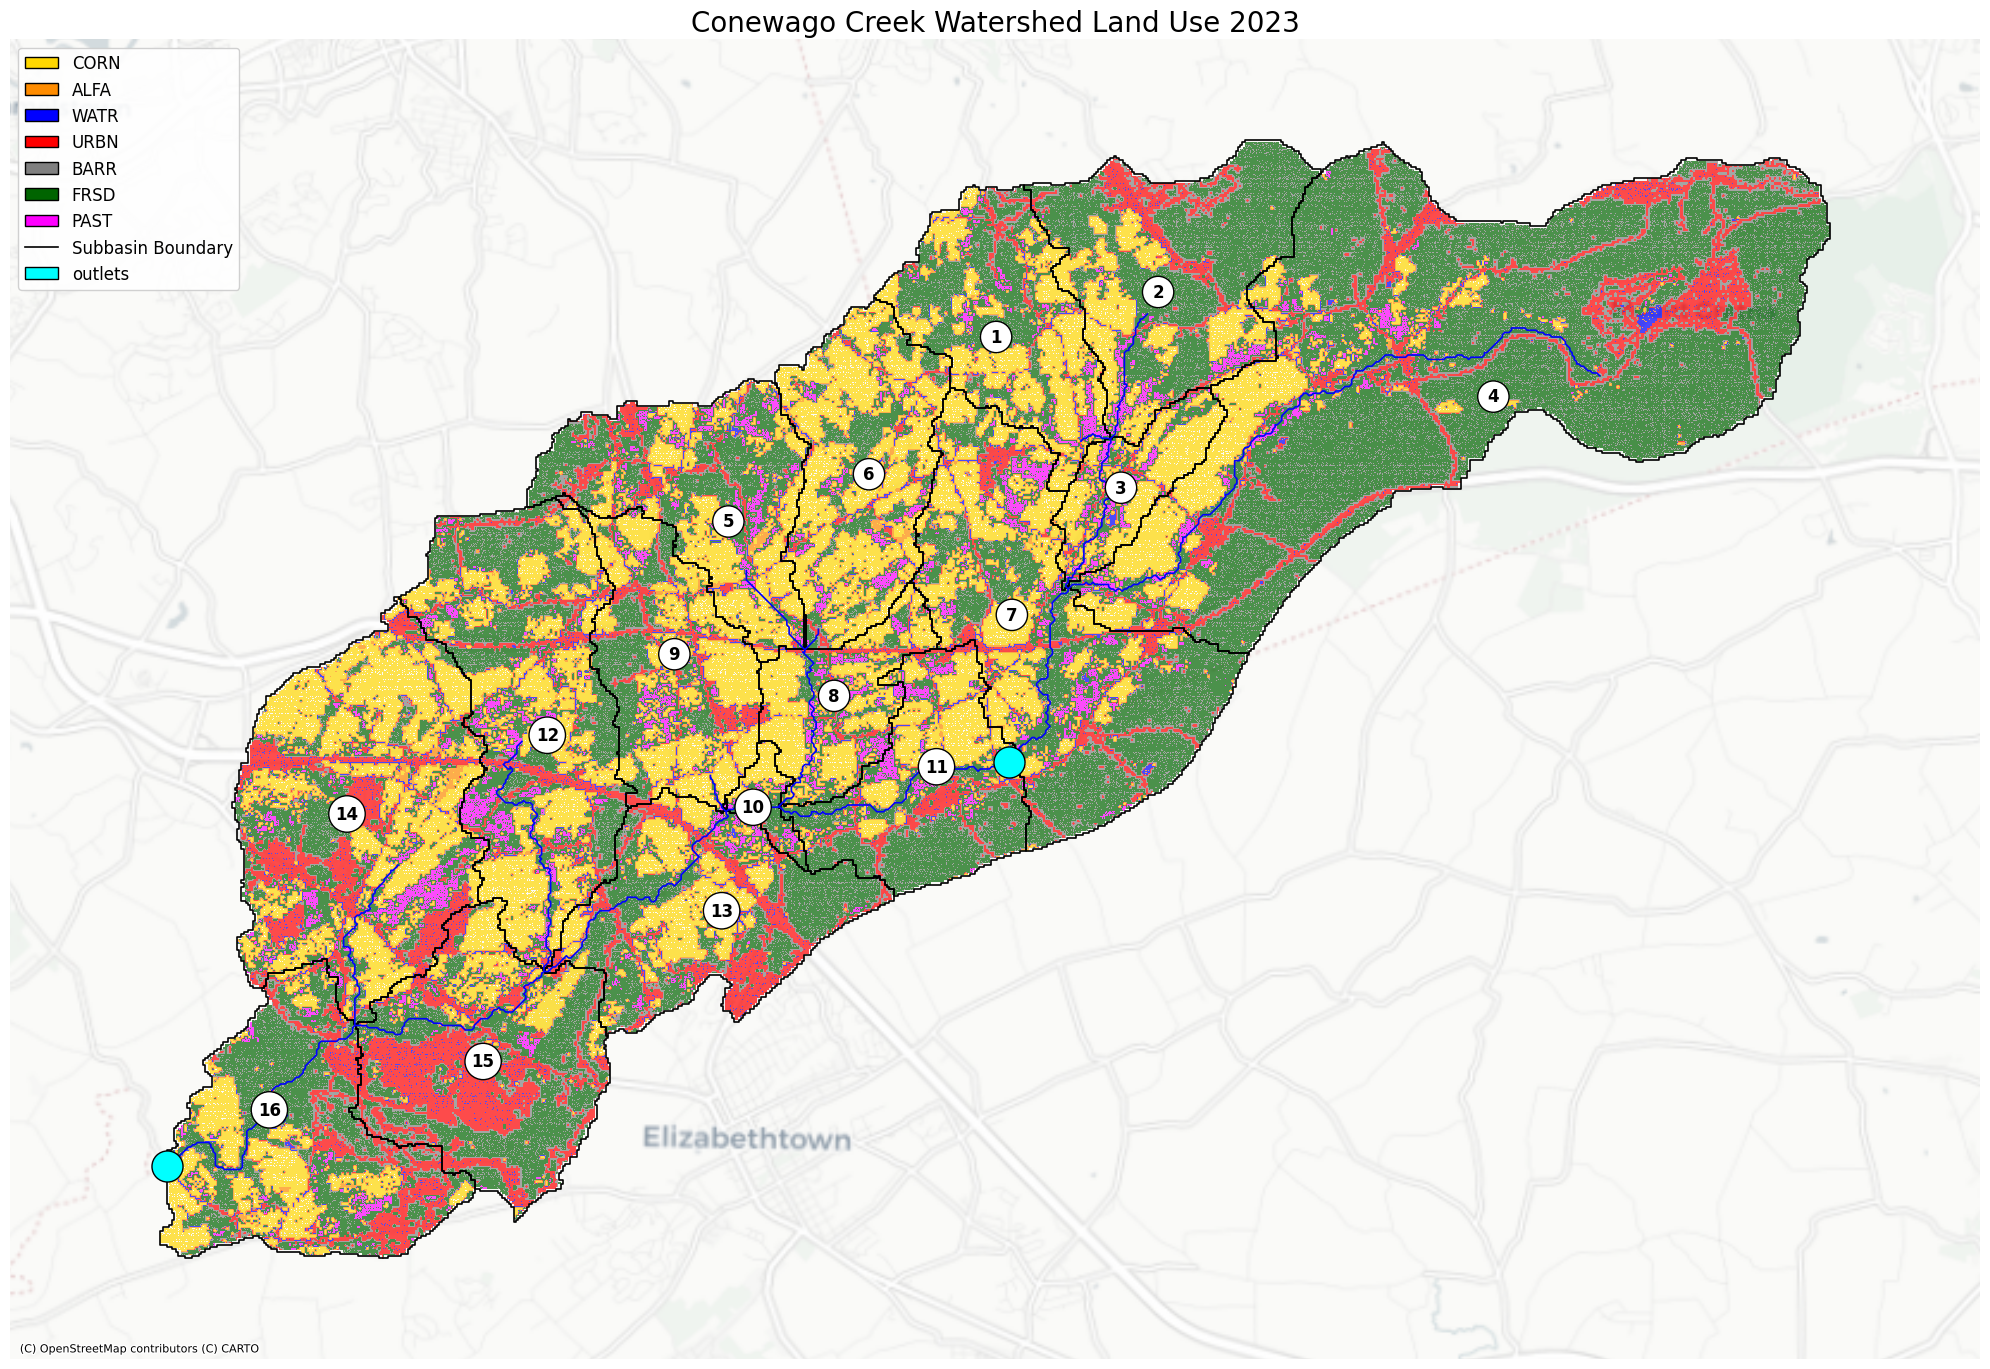

In [ ]:
# --- PLOT 1.3: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2023)
with rasterio.open(raster_files[2023]) as src:
    out_img, out_transform = mask(src, gdf.geometry, crop=True)
    reclassed_2023 = reclassify_array(out_img[0], reclass_map)
    
    reclassed_2023 = reclassed_2023.astype('float')
    reclassed_2023[reclassed_2023 == 0] = np.nan
    
    show(reclassed_2023, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=500, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom
xmin, ymin, xmax, ymax = gdf.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Conewago Creek Watershed Land Use 2023", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 500, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)

plt.tight_layout()
plt.savefig('LUmap2023_big_outlets.png', dpi=600)
plt.show()

Generating Bar Plot...


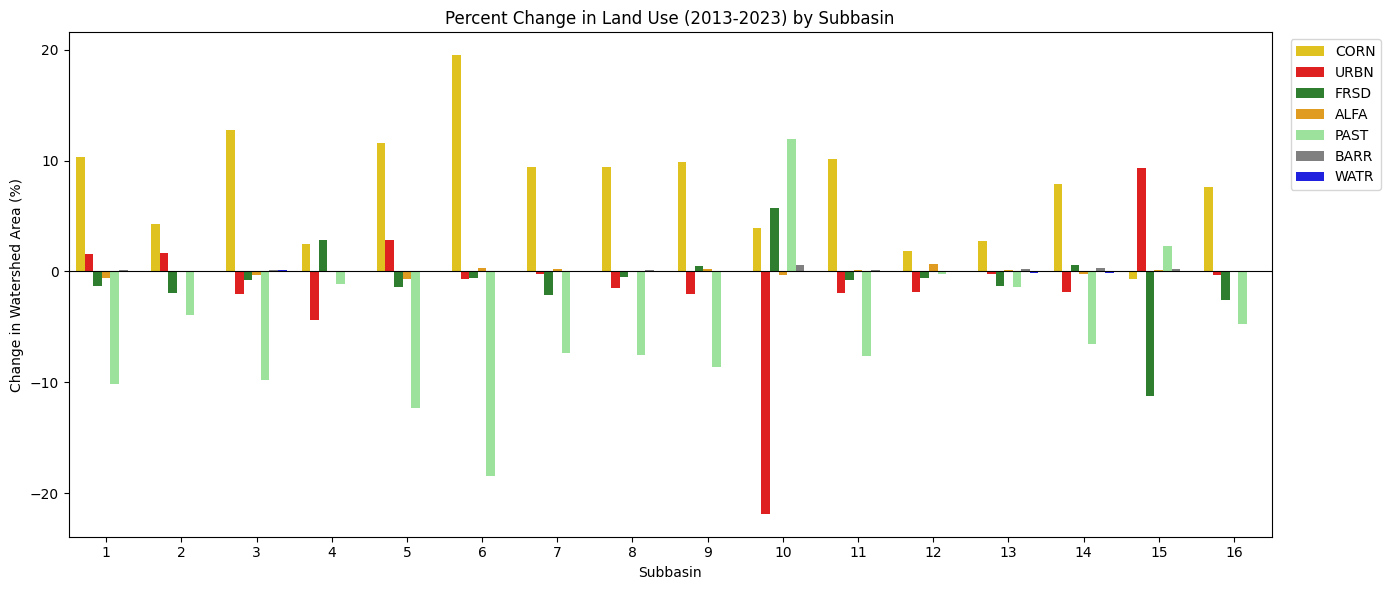

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- PLOT 2: Percent Change Bar Plot ---
print("Generating Bar Plot...")


palette_dict = {
    'CORN': 'gold', 'URBN': 'red', 'FRSD': 'forestgreen',
    'ALFA': 'orange', 'PAST': 'lightgreen', 'BARR': 'grey',
    'WATR': 'blue'
}

df_melt = df_stats.melt(id_vars=['Subbasin'], value_vars=[f'{lu}_Change' for lu in lu_types],
                        var_name='LandUse', value_name='Change_Pct')
df_melt['LandUse'] = df_melt['LandUse'].str.replace('_Change', '')

plt.figure(figsize=(14, 6))
sns.barplot(data=df_melt, x='Subbasin', y='Change_Pct', hue='LandUse', palette=palette_dict)
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Percent Change in Land Use (2013-2023) by Subbasin")
plt.ylabel("Change in Watershed Area (%)")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.savefig('LUchange_barplot.png', dpi=600)
plt.show()

Generating Matrix Heatmaps...


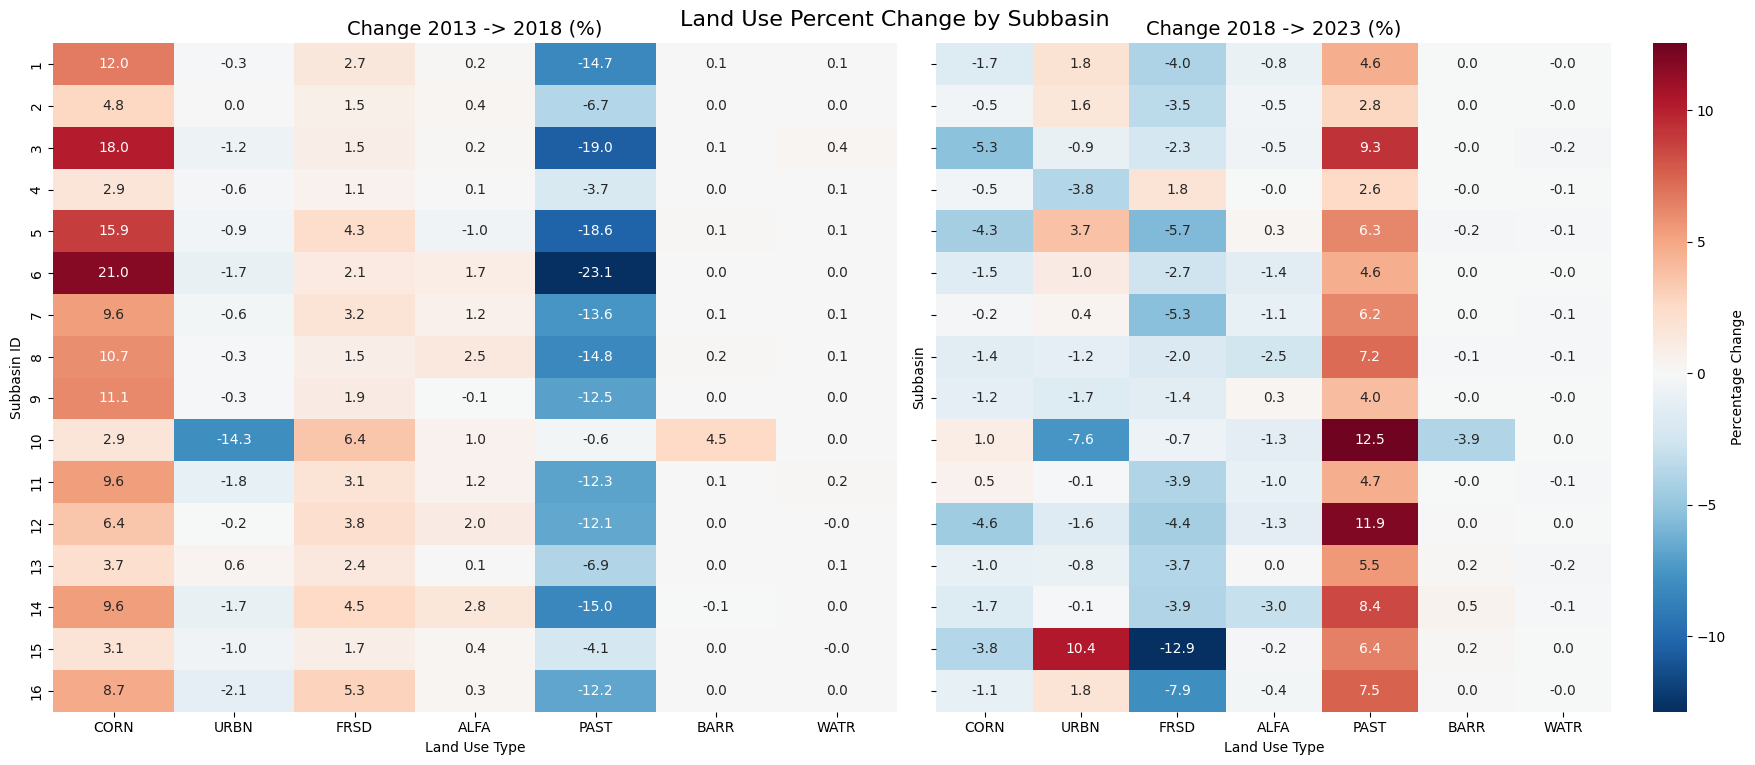

In [ ]:
# --- PLOT 3: Heatmaps ---
print("Generating Matrix Heatmaps...")
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

def get_heatmap_data(df, cols, subbasin_col='Subbasin'):
    data = df.set_index(subbasin_col)[cols]
    data.columns = [c.split('_')[0] for c in data.columns]
    return data

data_13_18 = get_heatmap_data(df_stats, cols_13_18)
sns.heatmap(data_13_18, ax=axes[0], cmap="RdBu_r", center=0, annot=True, fmt=".1f", cbar=False)
axes[0].set_title("Change 2013 -> 2018 (%)", fontsize=14)
axes[0].set_xlabel("Land Use Type")
axes[0].set_ylabel("Subbasin ID")

data_18_23 = get_heatmap_data(df_stats, cols_18_23)
sns.heatmap(data_18_23, ax=axes[1], cmap="RdBu_r", center=0, annot=True, fmt=".1f", 
            cbar_kws={'label': 'Percentage Change'})
axes[1].set_title("Change 2018 -> 2023 (%)", fontsize=14)
axes[1].set_xlabel("Land Use Type")

plt.suptitle("Land Use Percent Change by Subbasin", fontsize=16, y=0.95)
plt.tight_layout()
plt.savefig('LUchange_matrix.png', dpi=600)
plt.show()

## Subbasin plots

### SUB6

In [ ]:
# Subbasin_6

# --- PLOT 1.1: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2013)
with rasterio.open(raster_files[2013]) as src:
    out_img, out_transform = mask(src, gdf_6.geometry, crop=True)
    reclassed_2013 = reclassify_array(out_img[0], reclass_map)

    reclassed_2013 = reclassed_2013.astype('float')
    reclassed_2013[reclassed_2013 == 0] = np.nan
    
    show(reclassed_2013, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf_6.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
# gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
# gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=200, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf_6.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf_6.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom to Watershed Extent (plus margin)
xmin, ymin, xmax, ymax = gdf_6.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Subbasin 6 Land Use 2013", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 200, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.savefig('Sub_6_LUmap2013.png', dpi=600)
plt.show()

Generating Map...


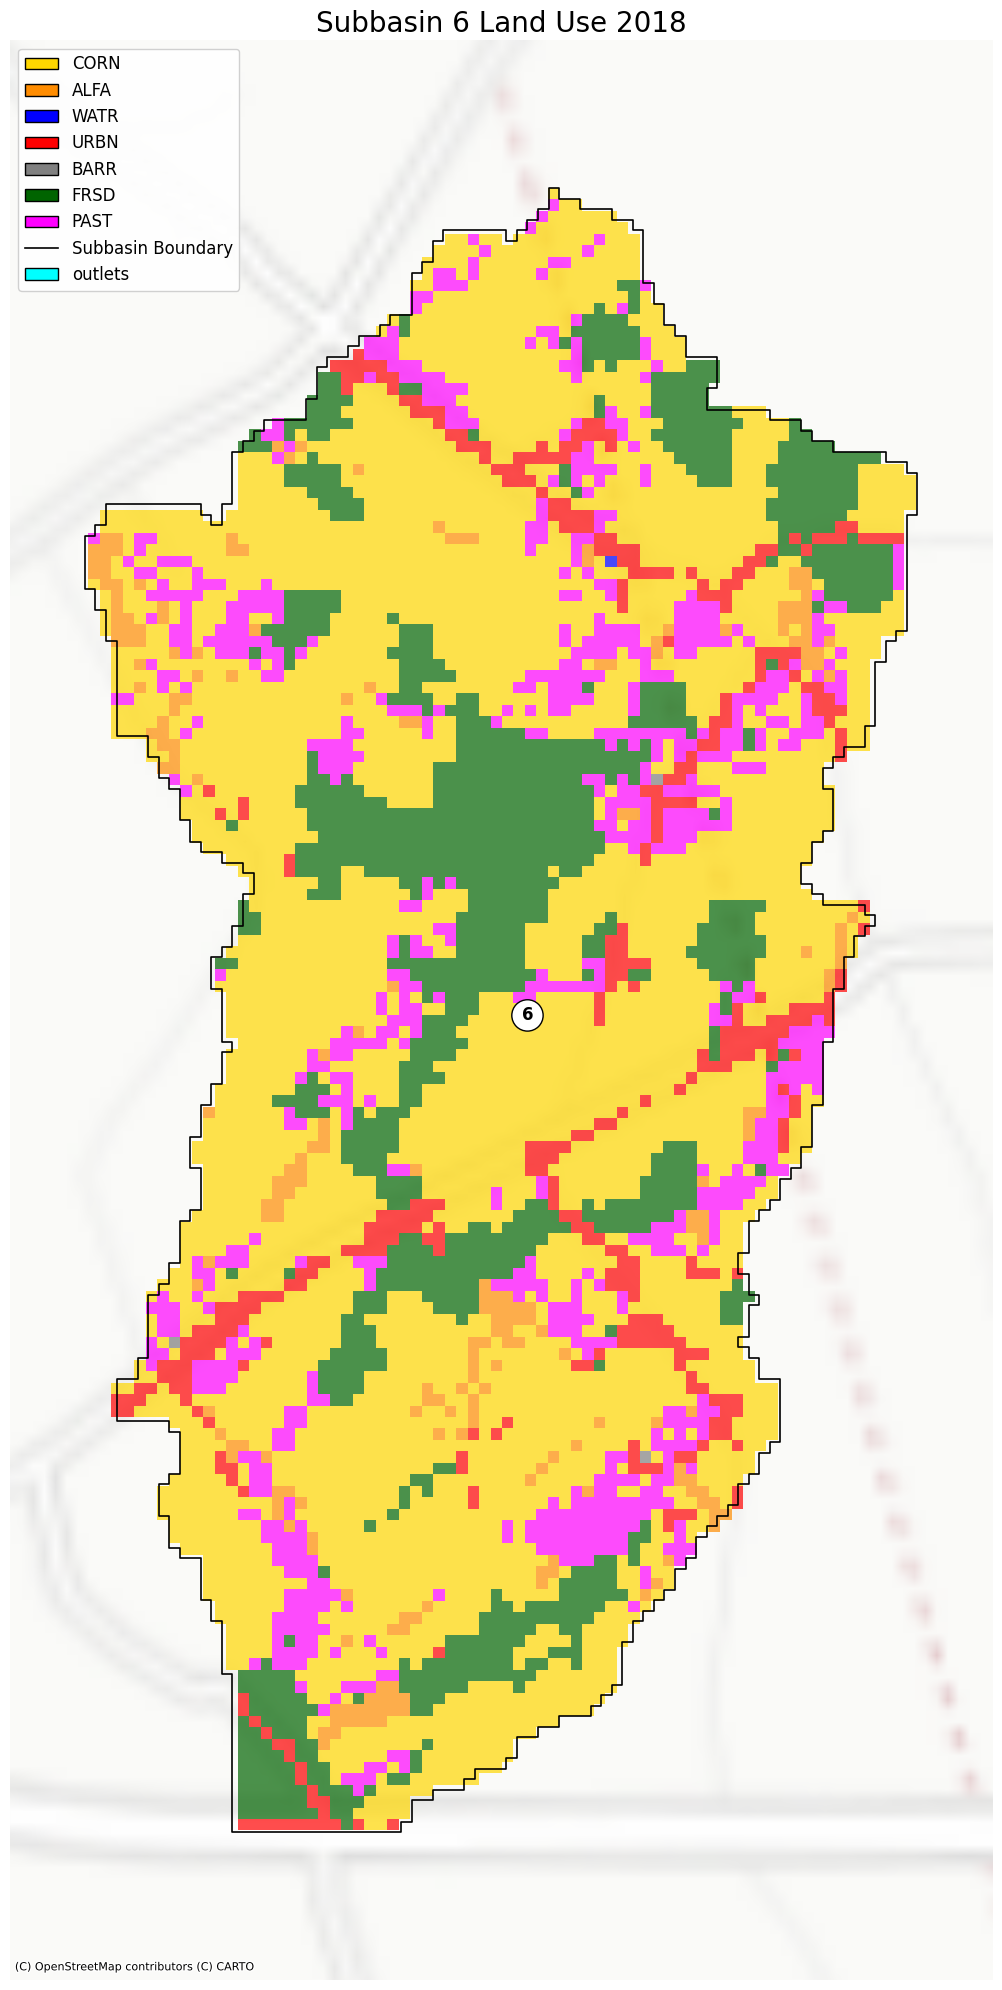

In [ ]:
# Subbasin_6

# --- PLOT 1.1: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2013)
with rasterio.open(raster_files[2018]) as src:
    out_img, out_transform = mask(src, gdf_6.geometry, crop=True)
    reclassed_2018 = reclassify_array(out_img[0], reclass_map)
    
    # CRITICAL: Convert 0 (No Data/Outside) to NaN so it becomes transparent
    # This ensures the basemap shows through outside the watershed boundaries
    reclassed_2018 = reclassed_2018.astype('float')
    reclassed_2018[reclassed_2018 == 0] = np.nan
    
    show(reclassed_2018, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf_6.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
# gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
# gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=200, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf_6.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf_6.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom
xmin, ymin, xmax, ymax = gdf_6.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Subbasin 6 Land Use 2018", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 200, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.savefig('Sub_6_LUmap2018.png', dpi=600)
plt.show()

Generating Map...


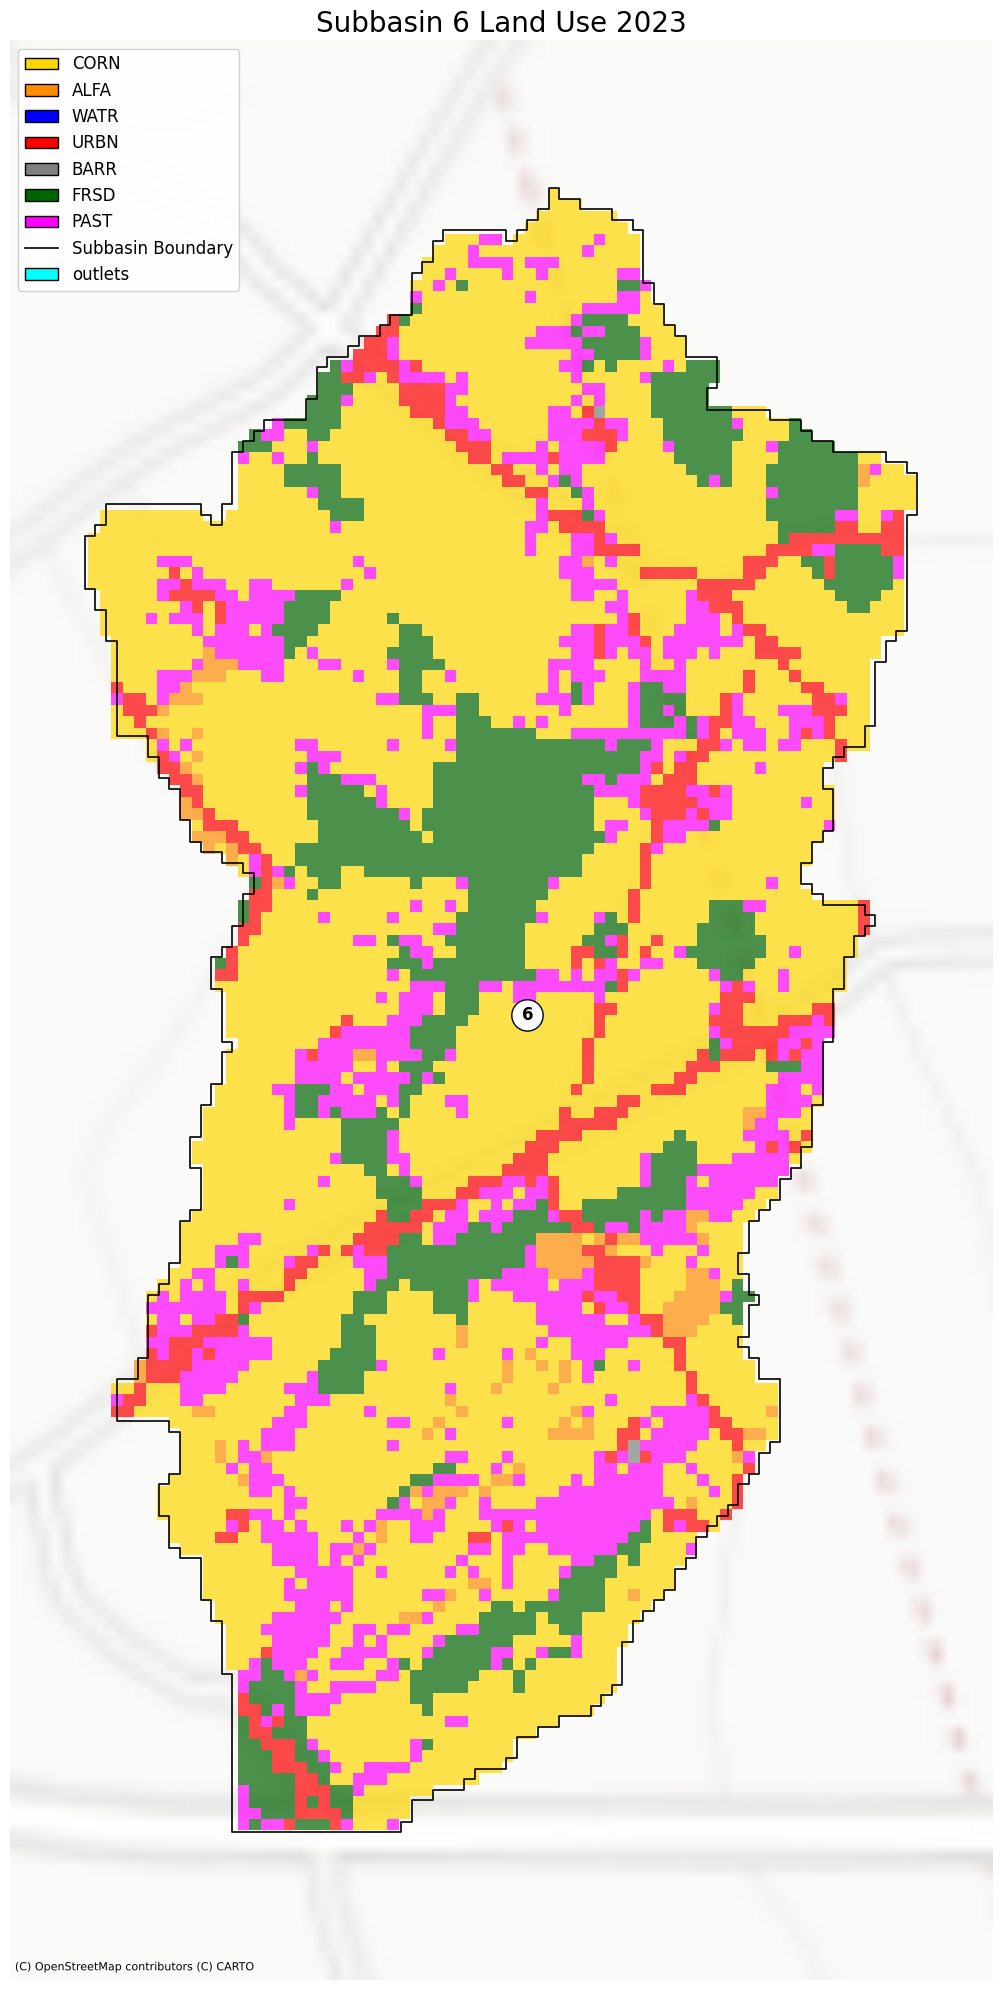

In [ ]:
# Subbasin_6

# --- PLOT 1.1: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2023)
with rasterio.open(raster_files[2023]) as src:
    out_img, out_transform = mask(src, gdf_6.geometry, crop=True)
    reclassed_2023 = reclassify_array(out_img[0], reclass_map)
    
    reclassed_2023 = reclassed_2023.astype('float')
    reclassed_2023[reclassed_2023 == 0] = np.nan
    
    show(reclassed_2023, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf_6.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
# gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
# gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=200, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf_6.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf_6.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom to Watershed Extent (plus margin)
xmin, ymin, xmax, ymax = gdf_6.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Subbasin 6 Land Use 2023", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 200, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.savefig('Sub_6_LUmap2023.png', dpi=600)
plt.show()

### SUB15

Generating Map...


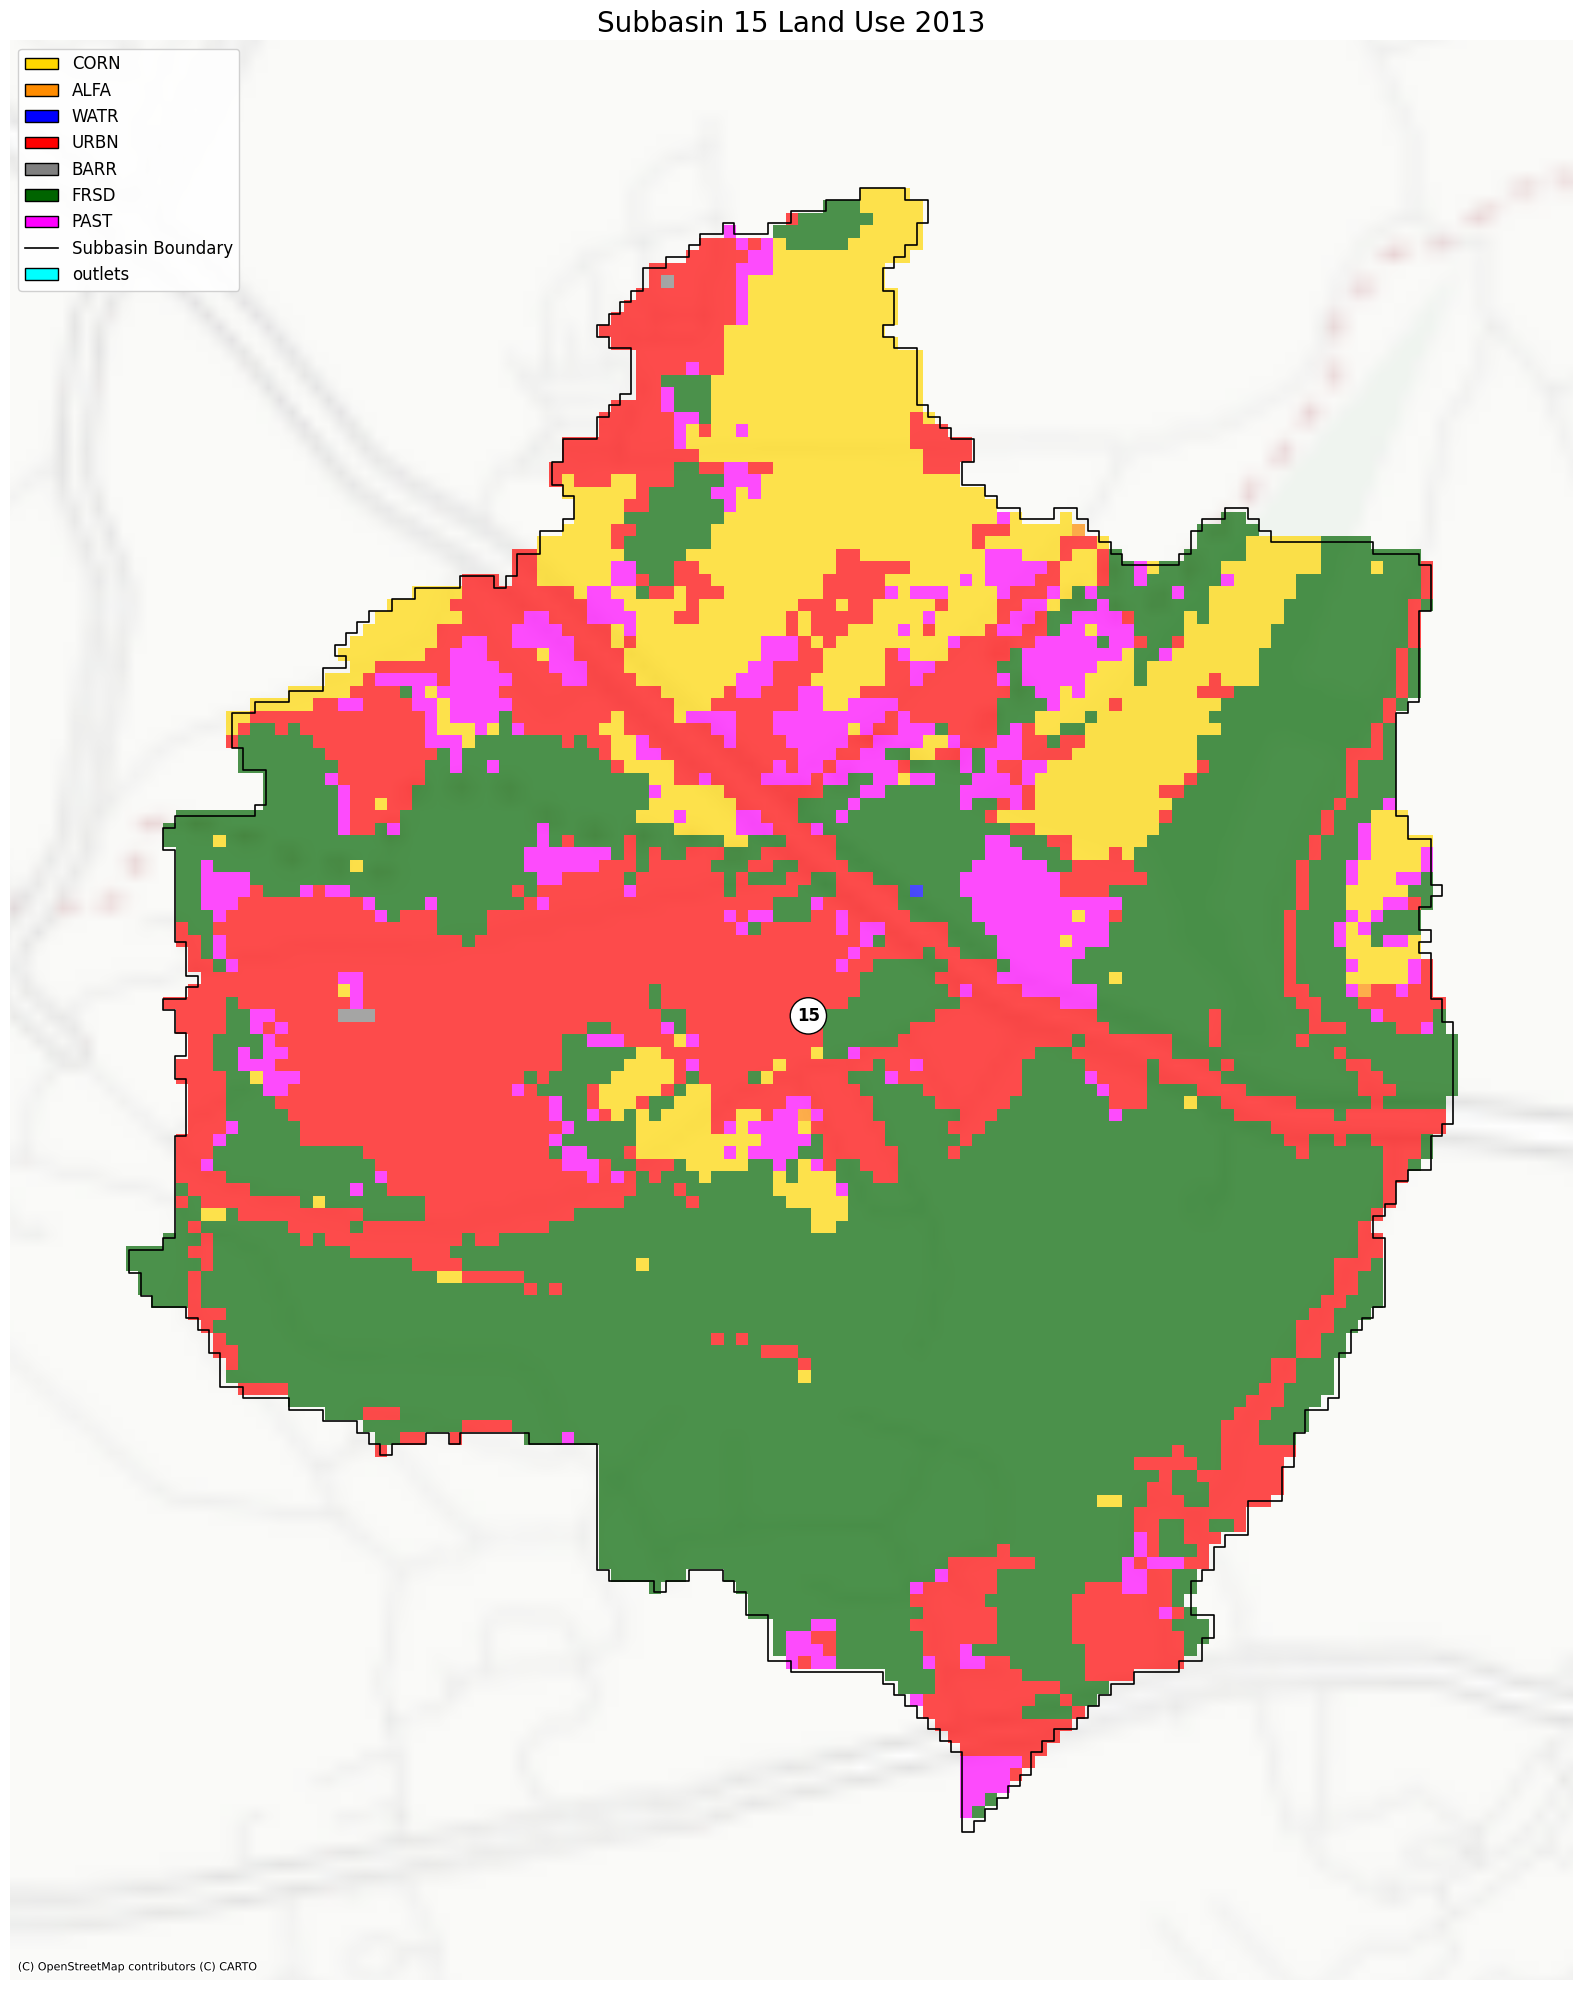

In [ ]:
# Subbasin_15

# --- PLOT 1.1: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2013)
with rasterio.open(raster_files[2013]) as src:
    out_img, out_transform = mask(src, gdf_15.geometry, crop=True)
    reclassed_2013 = reclassify_array(out_img[0], reclass_map)

    reclassed_2013 = reclassed_2013.astype('float')
    reclassed_2013[reclassed_2013 == 0] = np.nan
    
    show(reclassed_2013, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf_15.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
# gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
# gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=200, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf_15.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf_15.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom
xmin, ymin, xmax, ymax = gdf_15.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Subbasin 15 Land Use 2013", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 200, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.savefig('Sub_15_LUmap2013.png', dpi=600)
plt.show()

Generating Map...


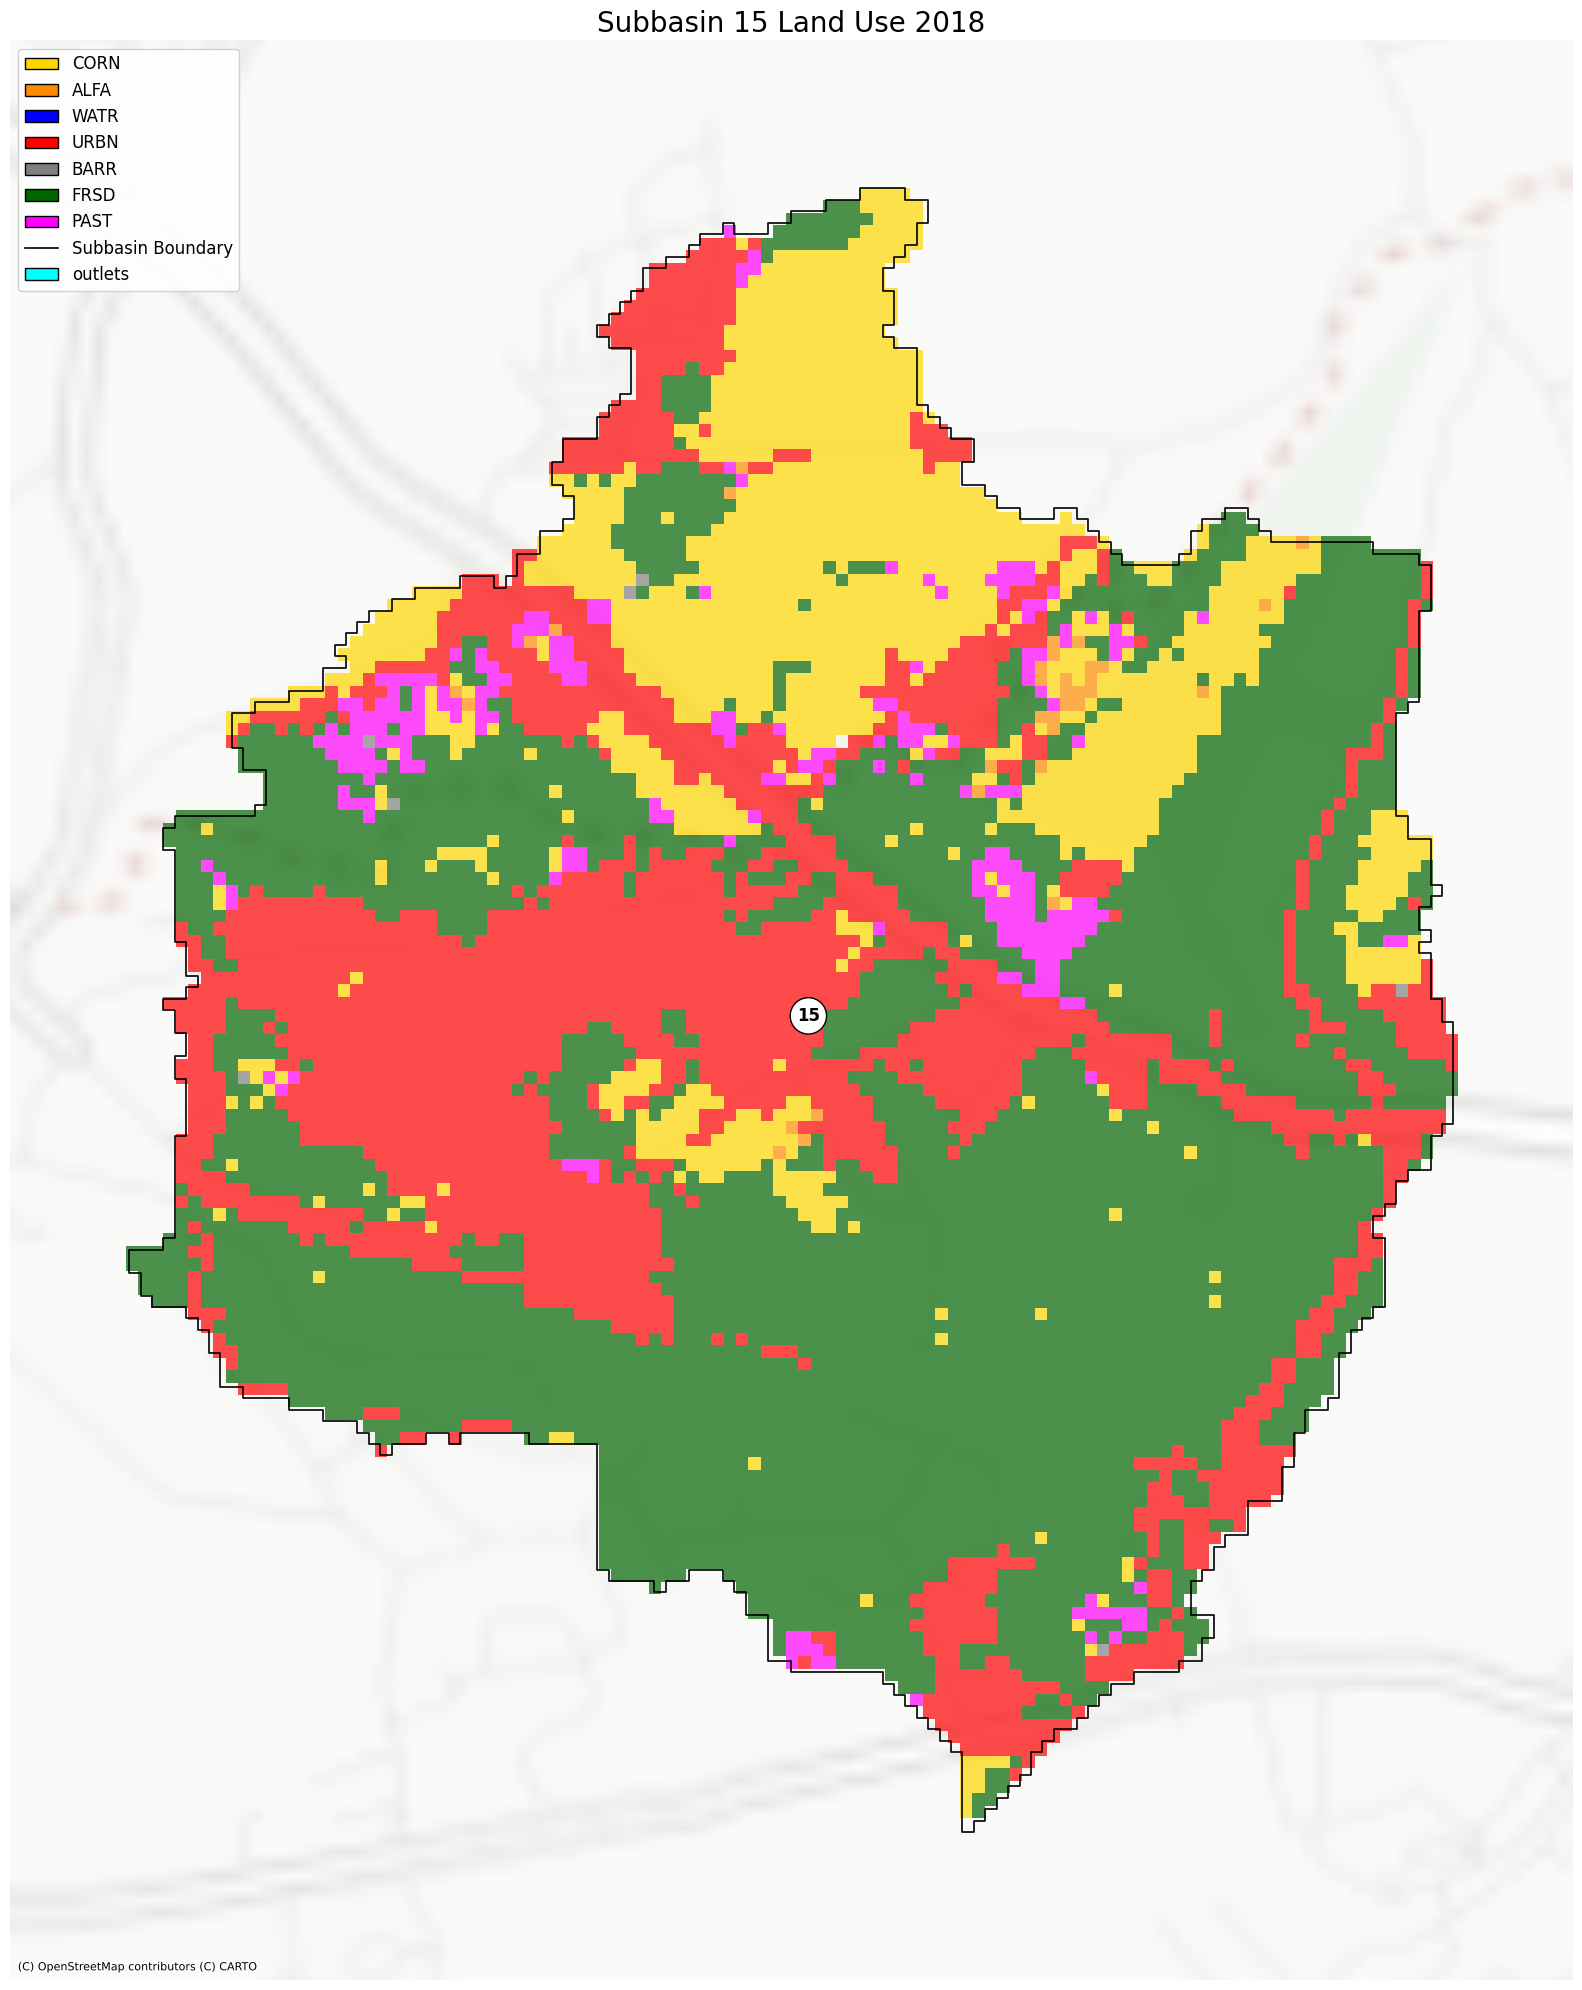

In [ ]:
# Subbasin_15

# --- PLOT 1.1: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2018)
with rasterio.open(raster_files[2018]) as src:
    out_img, out_transform = mask(src, gdf_15.geometry, crop=True)
    reclassed_2018 = reclassify_array(out_img[0], reclass_map)
    
    reclassed_2018 = reclassed_2018.astype('float')
    reclassed_2018[reclassed_2018 == 0] = np.nan
    
    show(reclassed_2018, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf_15.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
# gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
# gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=200, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf_15.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf_15.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom to Watershed Extent (plus margin)
xmin, ymin, xmax, ymax = gdf_15.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Subbasin 15 Land Use 2018", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 200, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.savefig('Sub_15_LUmap2018.png', dpi=600)
plt.show()

Generating Map...


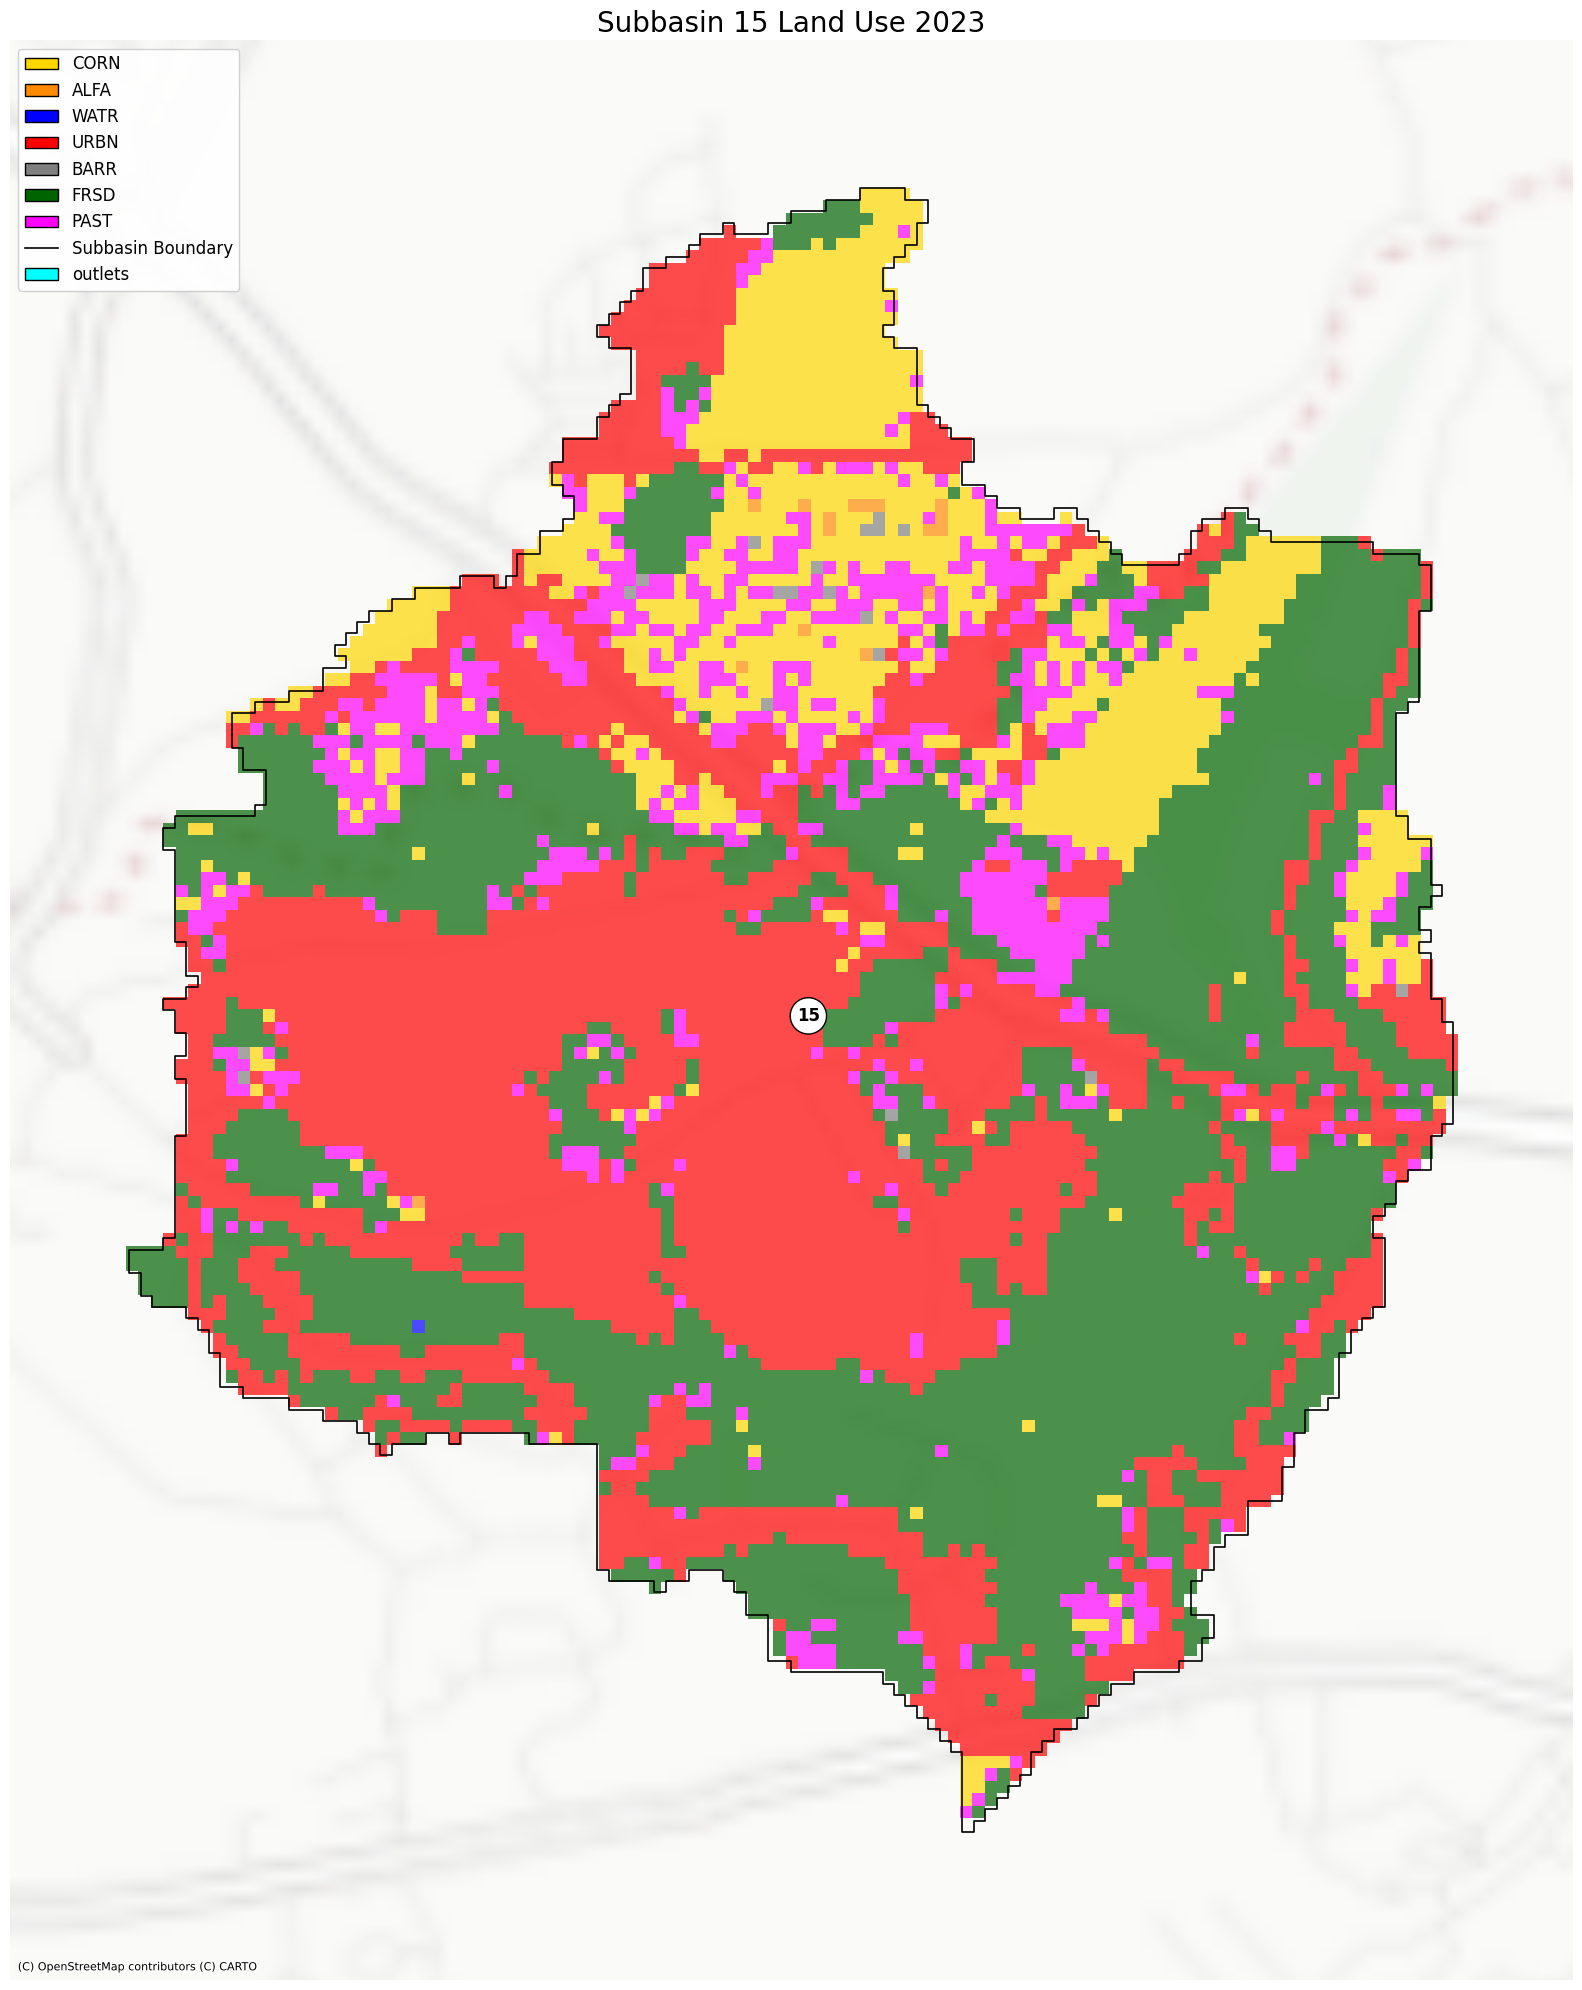

In [ ]:
# Subbasin_15

# --- PLOT 1.1: Map over Topographic Basemap (Basemap Visible, Raster Clipped) ---
print("Generating Map...")
fig, ax = plt.subplots(figsize=(20, 20))

# 1. Plot Raster (2013)
with rasterio.open(raster_files[2023]) as src:
    out_img, out_transform = mask(src, gdf_15.geometry, crop=True)
    reclassed_2023 = reclassify_array(out_img[0], reclass_map)
    
    reclassed_2023 = reclassed_2023.astype('float')
    reclassed_2023[reclassed_2023 == 0] = np.nan
    
    show(reclassed_2023, transform=out_transform, ax=ax, cmap=custom_cmap, norm=norm, alpha=0.7, zorder=2)

# 2.1. Plot Subbasin Boundaries
gdf_15.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2, zorder=3)

# 2.2. Plot rivers
# gdf_riv.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1.2, zorder=4)

# 2.2. Plot outlets
# gdf_outlet.plot(ax=ax, facecolor='cyan', edgecolor='black', markersize=200, zorder=5)

# 3. Add Subbasin Labels with Circular Halo
for idx, row in gdf_15.iterrows():
    xy = row.geometry.representative_point().coords[0]
    sub_id = row.get('Subbasin', idx)
    ax.annotate(text=str(sub_id), xy=xy, ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black',
                # Circular halo to make numbers readable over the map
                bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="black", lw=1),
                zorder=4)

# 4. Add Lighter Basemap
ctx.add_basemap(ax, crs=gdf_15.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# 5. Set Zoom to Watershed Extent (plus margin)
xmin, ymin, xmax, ymax = gdf_15.total_bounds
margin_x = (xmax - xmin) * 0.09
margin_y = (ymax - ymin) * 0.09
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

ax.set_title("Subbasin 15 Land Use 2023", fontsize=20)
ax.set_axis_off()

# Legend
from matplotlib.patches import Patch,Circle
from matplotlib.lines import Line2D

patches = [Patch(facecolor=cmap_colors[i], edgecolor='black', label=list(class_labels.values())[i]) 
           for i in range(1, len(cmap_colors))] # Skip index 0 (NODATA)

outlet_patch = [Circle(xy=(0,0), facecolor='cyan', radius = 200, edgecolor='black', label='outlets')]

boundary_handle = Line2D([0], [0], color='black', linewidth=1.2, label='Subbasin Boundary')

# Filter labels to match patches (Skip 0/NODATA)
valid_labels = [class_labels[k] for k in sorted(class_labels.keys()) if k!=0]

ax.legend(handles=patches + [boundary_handle] + outlet_patch, 
          labels=valid_labels + ['Subbasin Boundary'] + ['outlets'],  
          loc='upper left', fontsize=12, framealpha=0.9)
plt.tight_layout()
plt.savefig('Sub_15_LUmap2023.png', dpi=600)
plt.show()